In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `C:\Users\tge13\Documents\optimal_control_julia\lec_19\Project.toml`


In [2]:
using LinearAlgebra
using Plots
using SparseArrays
using ControlSystems
using ForwardDiff

In [21]:
# Discrete dynamics
h = 0.1   # time step
A = [1 h; 0 1]
B = [0.5*h*h; h]
C = [1.0 0]

1×2 Matrix{Float64}:
 1.0  0.0

## Gaussian Noise

In [22]:
W = B*0.1*B'
V = Array(0.1*I(1));
# V = 0.1 

In [23]:
n = 2     # number of state
m = 1     # number of controls
Tfinal = 10.0 # final time
N = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(N-1), step=h));

## LQR Cost

In [24]:
Q = Array(1.0 * I(n))
R = Array(0.1 * I(m))

1×1 Matrix{Float64}:
 0.1

## Acquire Infinite LQR Gain

In [25]:
P = dare(A, B, Q, R)
K = dlqr(A, B, Q, R)

1×2 Matrix{Float64}:
 2.5857  3.44344

## Initial State Setup

In [26]:
# real initial state
x0 = [1.0; 0.0]
Σ0 = Array(1.0 * I(n))

# esmation start state - wrong state
x̂0 = [0.0; 0.0]

2-element Vector{Float64}:
 0.0
 0.0

In [27]:
# GT 
xhist = zeros(n, N)
xhist[:,1] = x0

# estimations
x̂hist = zeros(n, N)
Σhist = zeros(n, n, N)

# LQR control
uhist = zeros(m, N)

# Generated Measurements
yhist = zeros(m, N);

## KF Setup

In [28]:
# Generate measurement
yhist[:,1] = C*xhist[:,1] + sqrt(V)*randn(m)

# First KF step
z = yhist[:,1] - C*x̂0
S = C*Σ0*C' + V
L = Σ0*C'*inv(S)

x̂hist[:,1] .= x̂0 + L*z
Σhist[:,:,1] .= (I - L*C)*Σ0*(I - L*C)' + L*V*L'

# LQR controller
uhist[:,1] .= -K*(x̂hist[:,1])

# GT step
xhist[:,2] .= A*xhist[:,1] + B.*uhist[:,1] + sqrt(W)*randn(n)

2-element view(::Matrix{Float64}, :, 2) with eltype Float64:
  0.9831007422848814
 -0.3379851538373492

## KF rollout

In [29]:
for k in 2:(N-1)
    # Generate measurement
    yhist[:,k] .= C*xhist[:,k-1] + sqrt(V)*randn(m)

    # prediction update
    x̂ = A*x̂hist[:,k-1] + B.*uhist[:,k-1]
    Σ = A*Σhist[:,:,k-1]*A' + W

    # measurement update
    z = yhist[:,k-1] - C*x̂
    S = C*Σ*C' + V

    # KF Gain
    L = Σ*C'*inv(S)

    # state/cov update
    x̂hist[:,k] .= x̂ + L*z
    Σhist[:,:,k] .= (I - L*C)*Σ*(I - L*C)' + L*V*L'

    # LQR controller
    uhist[:,k] .= -K*(x̂hist[:,k])

    # GT step
    xhist[:,k] .= A*xhist[:,k-1] + B.*uhist[:,k-1] + sqrt(W)*randn(n)
end

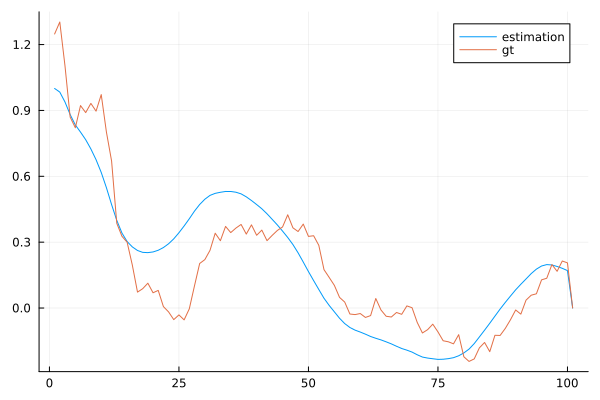

In [30]:
plot(xhist[1,:], label="estimation")
plot!(x̂hist[1,:], label="gt")

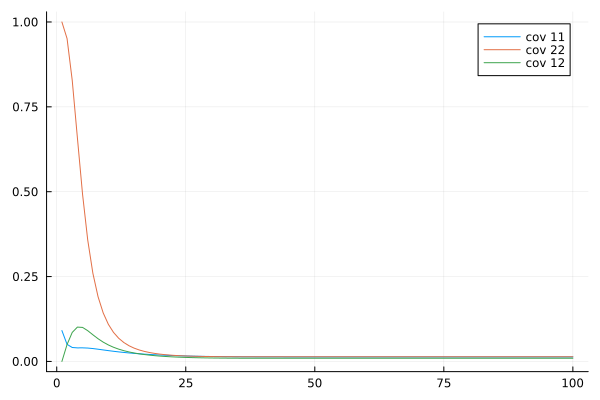

In [31]:
#Covariance and Kalman gain converge to steady-state values in the LTI case
#(just like LQR gain + cost-to-go Hessian)
plot(Σhist[1,1,1:N-1], label="cov 11")
plot!(Σhist[2,2,1:N-1], label="cov 22")
plot!(Σhist[1,2,1:N-1], label="cov 12")

In [32]:
L

2×1 Matrix{Float64}:
 0.13185116517964043
 0.09317476869888432

## KF again - Using Converged Gain

In [33]:
# GT 
xhist = zeros(n, N)
xhist[:,1] = x0

# estimations
x̂hist = zeros(n, N)
Σhist = zeros(n, n, N)

# LQR control
uhist = zeros(m, N)

# Generated Measurements
yhist = zeros(m, N);

In [34]:
# Generate measurement
yhist[:,1] = C*xhist[:,1] + sqrt(V)*randn(m)

# First x guess
x̂hist[:,1] .= x̂0 + L*z

# LQR controller
uhist[:,1] .= -K*(x̂hist[:,1])

# GT step
xhist[:,2] .= A*xhist[:,1] + B.*uhist[:,1] + sqrt(W)*randn(n)

2-element view(::Matrix{Float64}, :, 2) with eltype Float64:
 1.0010417699264307
 0.020835398613647527

In [35]:
for k in 2:(N-1)
    # Generate measurement
    yhist[:,k] .= C*xhist[:,k-1] + sqrt(V)*randn(m)

    # prediction update
    x̂ = A*x̂hist[:,k-1] + B.*uhist[:,k-1]

    # measurement update
    z = yhist[:,k-1] - C*x̂

    # state/cov update
    x̂hist[:,k] .= x̂ + L*z

    # LQR controller
    uhist[:,k] .= -K*(x̂hist[:,k])

    # GT step
    xhist[:,k] .= A*xhist[:,k-1] + B.*uhist[:,k-1] + sqrt(W)*randn(n)
end

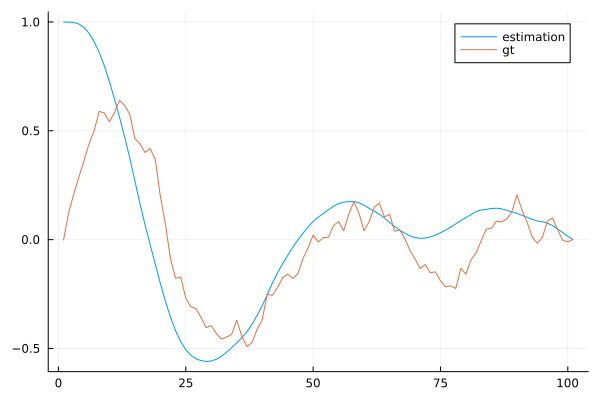

In [36]:
plot(xhist[1,:], label="estimation")
plot!(x̂hist[1,:], label="gt")